# Getting Started

In this notebook, we will walk you through a minimal example for candidate generation and re-reranking with the [Quaero](https://quaerofrenchmed.limsi.fr/) corpus.

## Preparation

Go to the root folder of the repository and run the following commands

`xmen dict conf/quaero.yaml`

This command creates the Quaero-specific UMLS subset as a jsonl file.
If you don't have access to UMLS metathesaurus 2014AB release, you can adapt the yaml file to point to any other release.

`xmen index conf/quaero.yaml --all`

This command creates the indices used candidate generations (both TF-IDF and SapBERT).

By default, all files are written to `~/.cache/xmen`, unless configured otherwise.

## Loading Knowledge Base and Dataset

In [2]:
from pathlib import Path
base_path = Path.home() / ".cache/xmen/quaero"

In [3]:
# Load Quaero MEDLINE subset through BigBIO dataloader
from datasets import load_dataset
dataset = load_dataset("bigbio/quaero", "quaero_medline_bigbio_kb")

Found cached dataset quaero (/home/Florian.Borchert/.cache/huggingface/datasets/bigbio___quaero/quaero_medline_bigbio_kb/1.0.0/c215a01af5fd15163e392e2f78a4f67f1fe3567d92f53b7f907c95e55dcdfe93)


  0%|          | 0/3 [00:00<?, ?it/s]

In [4]:
# Load knowledge base
from xmen import load_kb
kb = load_kb(base_path / "quaero.jsonl")

# Candidate Generation

We use the pre-computed indices to retrieve the 64 most similar concepts for each mention

In [5]:
# Generate candidates with Ensemble of TF-IDF + SapBERT
from xmen.linkers import default_ensemble
linker = default_ensemble(base_path / "index")

[09/20/23 14:32:55] INFO     Loading hierarchical faiss index                                ]8;id=423745;file:///mnt/nfs/home/Florian.Borchert/workspace/xmen/xmen/linkers/sap_bert_linker.py\sap_bert_linker.py]8;;\:]8;id=169665;file:///mnt/nfs/home/Florian.Borchert/workspace/xmen/xmen/linkers/sap_bert_linker.py#153\153]8;;\

                    INFO     Loading index from                                                 ]8;id=67971;file:///mnt/nfs/home/Florian.Borchert/workspace/xmen/xmen/linkers/faiss_indexer.py\faiss_indexer.py]8;;\:]8;id=587136;file:///mnt/nfs/home/Florian.Borchert/workspace/xmen/xmen/linkers/faiss_indexer.py#64\64]8;;\
                             /home/Florian.Borchert/.cache/xmen/quaero/index/sapbert/embed_fais                    
                             s_hier.pickle                                                                         

[09/20/23 14:33:03] INFO     Loaded index of type <class 'faiss.swigfaiss.IndexHNSWFlat'> and   ]8;id=421559;file:///mnt/nfs/home/Florian.Borchert/workspace/xmen/xmen/linkers/faiss_indexer.py\faiss_indexer.py]8;;\:]8;id=621692;file:///mnt/nfs/home/Florian.Borchert/workspace/xmen/xmen/linkers/faiss_indexer.py#66\66]8;;\
                             size 6910830                                                                          

In [6]:
candidates = linker.predict_batch(dataset, top_k=64)

Map:   0%|          | 0/833 [00:00<?, ? examples/s]

Map:   0%|          | 0/833 [00:00<?, ? examples/s]

Map:   0%|          | 0/832 [00:00<?, ? examples/s]

In [7]:
from xmen.evaluation import evaluate
evaluate(dataset['test'], candidates['test'])

{'strict': {'precision': 0.5802389409105586,
  'recall': 0.5804263565891473,
  'fscore': 0.5803326336186015,
  'ptp': 1797,
  'fp': 1300,
  'rtp': 1797,
  'fn': 1299,
  'n_docs_system': 833,
  'n_annos_system': 3103,
  'n_docs_gold': 833,
  'n_annos_gold': 3097}}

# Semantic Group Filtering

In [8]:
from xmen.data import SemanticGroupFilter
candidates = SemanticGroupFilter(kb).transform_batch(candidates)

Map:   0%|          | 0/833 [00:00<?, ? examples/s]

Map:   0%|          | 0/833 [00:00<?, ? examples/s]

Map:   0%|          | 0/832 [00:00<?, ? examples/s]

In [9]:
evaluate(dataset['test'], candidates['test'])

{'strict': {'precision': 0.6606276285991588,
  'recall': 0.6595607235142119,
  'fscore': 0.6600937449490868,
  'ptp': 2042,
  'fp': 1049,
  'rtp': 2042,
  'fn': 1054,
  'n_docs_system': 833,
  'n_annos_system': 3095,
  'n_docs_gold': 833,
  'n_annos_gold': 3097}}

# Reranking

## Using a Pre-trained Model for Reranking

When no are little annotated training data is available, a pre-trained model can provide good re-ranking performance.
Here, we use a cross-encoder that was trained on an automatically translated version of MedMentions (see the notebook [01_Translation.ipynb](01_Translation.ipynb))

In [10]:
from xmen.reranking.cross_encoder import *
ce_dataset = CrossEncoderReranker.prepare_data(candidates, dataset, kb)

Context length: 128
Use NIL values: True


  0%|          | 0/2994 [00:00<?, ?it/s]

  0%|          | 0/2994 [00:00<?, ?it/s]

  0%|          | 0/2994 [00:00<?, ?it/s]

  0%|          | 0/3103 [00:00<?, ?it/s]

  0%|          | 0/3103 [00:00<?, ?it/s]

  0%|          | 0/3103 [00:00<?, ?it/s]

  0%|          | 0/2977 [00:00<?, ?it/s]

  0%|          | 0/2977 [00:00<?, ?it/s]

  0%|          | 0/2977 [00:00<?, ?it/s]

In [11]:
# CE re-ranker, pre-trained on French translation of MedMentions
rr = CrossEncoderReranker.load('../models/fr_ce_medmentions', device=0)

In [12]:
# Predict on test set
prediction = rr.rerank_batch(candidates["test"], ce_dataset["test"], allow_nil=False)

Batches:   0%|          | 0/3095 [00:00<?, ?it/s]

Map:   0%|          | 0/833 [00:00<?, ? examples/s]

Map:   0%|          | 0/833 [00:00<?, ? examples/s]

In [13]:
evaluate(dataset['test'], prediction)

{'strict': {'precision': 0.7234248788368336,
  'recall': 0.7231912144702842,
  'fscore': 0.7233080277822647,
  'ptp': 2239,
  'fp': 856,
  'rtp': 2239,
  'fn': 857,
  'n_docs_system': 833,
  'n_annos_system': 3095,
  'n_docs_gold': 833,
  'n_annos_gold': 3097}}

## Training a Fully-supervised Model

Finally, with enough training data, we can also train a fully supervsied cross-encoder to learn a better task-specific ranking.

The cross-encoder is trained with batches of 64 candidates. 
We keep the checkpoint that maximizes accuracy@1 on the validation set.

In [14]:
# Train the cross-encoder on the training set and use the validation set for model selection
rr_fs = CrossEncoderReranker()
# Note: we train for 3 epochs only (you likely want to increase this for better performance)
args = CrossEncoderTrainingArgs(num_train_epochs=3)
rr_fs.fit(args, ce_dataset["train"].dataset, ce_dataset["validation"].dataset, show_progress_bar=False)

model_name := bert-base-multilingual-cased
num_train_epochs := 3
fp16 := True
label_smoothing := False
rank_regularization := 1.0
train_layers := None
softmax_loss := True
random_seed := 42
learning_rate := 2e-05


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual

2023-09-20 15:21:33 - EntityLinkingEvaluator: Evaluating the model on eval dataset after epoch 0:
2023-09-20 15:32:15 - Accuracy: 0.7236842105263158
2023-09-20 15:32:15 - Accuracy @ 5: 0.8609986504723347
2023-09-20 15:32:15 - Accuracy @ 64: 0.9946018893387314
2023-09-20 15:32:16 - Baseline Accuracy: 0.6686909581646424
2023-09-20 15:32:16 - Save model to ./output/cross_encoder
2023-09-20 15:50:03 - EntityLinkingEvaluator: Evaluating the model on eval dataset after epoch 1:
2023-09-20 16:00:46 - Accuracy: 0.7419028340080972
2023-09-20 16:00:46 - Accuracy @ 5: 0.8657219973009447
2023-09-20 16:00:46 - Accuracy @ 64: 0.9946018893387314
2023-09-20 16:00:46 - Baseline Accuracy: 0.6686909581646424
2023-09-20 16:00:46 - Save model to ./output/cross_encoder
2023-09-20 16:18:35 - EntityLinkingEvaluator: Evaluating the model on eval dataset after epoch 2:
2023-09-20 16:29:18 - Accuracy: 0.7493252361673415
2023-09-20 16:29:18 - Accuracy @ 5: 0.8728070175438597
2023-09-20 16:29:18 - Accuracy @ 64: 0

In [15]:
# Predict on test set
prediction_fs = rr_fs.rerank_batch(candidates["test"], ce_dataset["test"])

Batches:   0%|          | 0/3095 [00:00<?, ?it/s]

Map:   0%|          | 0/833 [00:00<?, ? examples/s]

Map:   0%|          | 0/833 [00:00<?, ? examples/s]

# Evaluation

## Metrics

We compute metrics for the predicted concepts vs. the gold-standard for different values of k

In [16]:
evaluate(dataset['test'], prediction_fs)

{'strict': {'precision': 0.7534426229508197,
  'recall': 0.7422480620155039,
  'fscore': 0.7478034493979824,
  'ptp': 2298,
  'fp': 752,
  'rtp': 2298,
  'fn': 798,
  'n_docs_system': 833,
  'n_annos_system': 3050,
  'n_docs_gold': 833,
  'n_annos_gold': 3097}}

In [17]:
from xmen.evaluation import evaluate_at_k
_ = evaluate_at_k(dataset['test'], candidates['test'])

Recall@1 0.6595607235142119
Recall@2 0.790374677002584
Recall@4 0.8449612403100775
Recall@8 0.8656330749354005
Recall@16 0.8853359173126615
Recall@32 0.8963178294573644
Recall@64 0.8998708010335917


In [18]:
_ = evaluate_at_k(dataset['test'], prediction_fs)

Recall@1 0.7422480620155039
Recall@2 0.8042635658914729
Recall@4 0.8394702842377261
Recall@8 0.8636950904392765
Recall@16 0.8788759689922481
Recall@32 0.8914728682170543
Recall@64 0.8959948320413437


## Error Analysis

To gain more insights into the ranking errors (and potential NER errors, which do not apply here), we use the `error_analysis` functionality of xmen

In [19]:
from xmen.evaluation import error_analysis

In [20]:
# Before re-ranking
ea_df = error_analysis(dataset['test'], candidates['test'])
ea_df.head(10)

,_word_len,_abbrev,pred_start,pred_end,pred_text,gt_start,gt_end,gt_text,entity_match_type,gold_concept,gold_type,pred_index,pred_index_score,pred_top,pred_top_score,document_id
0,1,False,0.0,5.0,[Etude],0.0,5.0,[Etude],tp,"{'db_name': 'UMLS', 'db_id': 'C0008972'}",PROC,-1.0,NaN,C0013621,0.692185,1009657
1,1,False,47.0,55.0,[Africain],47.0,55.0,[Africain],tp,"{'db_name': 'UMLS', 'db_id': 'C0027567'}",LIVB,0.0,0.863724,C0027567,0.863724,1009657
2,1,False,4.0,13.0,[gangrènes],4.0,13.0,[gangrènes],tp,"{'db_name': 'UMLS', 'db_id': 'C0017086'}",DISO,0.0,0.973051,C0017086,0.973051,1009808
3,2,False,4.0,22.0,[gangrènes gazeuses],4.0,22.0,[gangrènes gazeuses],tp,"{'db_name': 'UMLS', 'db_id': 'C0017105'}",DISO,0.0,0.935468,C0017105,0.935468,1009808
4,1,False,14.0,22.0,[gazeuses],14.0,22.0,[gazeuses],tp,"{'db_name': 'UMLS', 'db_id': 'C0017110'}",CHEM,2.0,0.808053,C0537495,0.858877,1009808
5,1,False,35.0,46.0,[tuberculose],35.0,46.0,[tuberculose],tp,"{'db_name': 'UMLS', 'db_id': 'C0041296'}",DISO,0.0,1.0,C0041296,1.0,1019393
6,2,False,35.0,53.0,[tuberculose bovine],35.0,53.0,[tuberculose bovine],tp,"{'db_name': 'UMLS', 'db_id': 'C0041307'}",DISO,0.0,1.0,C0041307,1.0,1019393
7,1,False,47.0,53.0,[bovine],47.0,53.0,[bovine],tp,"{'db_name': 'UMLS', 'db_id': 'C0007452'}",LIVB,3.0,1.0,C3667982,1.0,1019393
8,2,False,56.0,75.0,[Mycobacterium bovis],56.0,75.0,[Mycobacterium bovis],tp,"{'db_name': 'UMLS', 'db_id': 'C0026917'}",DISO,-1.0,NaN,C0041307,0.825099,1019393
9,1,False,78.0,86.0,[observés],78.0,86.0,[observés],tp,"{'db_name': 'UMLS', 'db_id': 'C0302523'}",PROC,1.0,0.852574,C0700325,0.852574,1019393


In [21]:
# After Re-Ranking
ea_df = error_analysis(dataset['test'], prediction_fs)
ea_df.head(10)

,_word_len,_abbrev,pred_start,pred_end,pred_text,gt_start,gt_end,gt_text,entity_match_type,gold_concept,gold_type,pred_index,pred_index_score,pred_top,pred_top_score,document_id
0,1,False,0.0,5.0,[Etude],0.0,5.0,[Etude],tp,"{'db_name': 'UMLS', 'db_id': 'C0008972'}",PROC,-1.0,NaN,NIL,NaN,1009657
1,1,False,47.0,55.0,[Africain],47.0,55.0,[Africain],tp,"{'db_name': 'UMLS', 'db_id': 'C0027567'}",LIVB,1.0,0.037974,C0085756,0.042189,1009657
2,1,False,4.0,13.0,[gangrènes],4.0,13.0,[gangrènes],tp,"{'db_name': 'UMLS', 'db_id': 'C0017086'}",DISO,0.0,0.04899,C0017086,0.04899,1009808
3,2,False,4.0,22.0,[gangrènes gazeuses],4.0,22.0,[gangrènes gazeuses],tp,"{'db_name': 'UMLS', 'db_id': 'C0017105'}",DISO,0.0,0.054722,C0017105,0.054722,1009808
4,1,False,14.0,22.0,[gazeuses],14.0,22.0,[gazeuses],tp,"{'db_name': 'UMLS', 'db_id': 'C0017110'}",CHEM,0.0,0.062369,C0017110,0.062369,1009808
5,1,False,35.0,46.0,[tuberculose],35.0,46.0,[tuberculose],tp,"{'db_name': 'UMLS', 'db_id': 'C0041296'}",DISO,0.0,0.050489,C0041296,0.050489,1019393
6,2,False,35.0,53.0,[tuberculose bovine],35.0,53.0,[tuberculose bovine],tp,"{'db_name': 'UMLS', 'db_id': 'C0041307'}",DISO,0.0,0.04899,C0041307,0.04899,1019393
7,1,False,47.0,53.0,[bovine],47.0,53.0,[bovine],tp,"{'db_name': 'UMLS', 'db_id': 'C0007452'}",LIVB,0.0,0.072256,C0007452,0.072256,1019393
8,2,False,56.0,75.0,[Mycobacterium bovis],56.0,75.0,[Mycobacterium bovis],tp,"{'db_name': 'UMLS', 'db_id': 'C0026917'}",DISO,-1.0,NaN,C0041307,0.433185,1019393
9,1,False,78.0,86.0,[observés],78.0,86.0,[observés],tp,"{'db_name': 'UMLS', 'db_id': 'C0302523'}",PROC,0.0,0.067624,C0302523,0.067624,1019393


<Axes: xlabel='pred_index'>

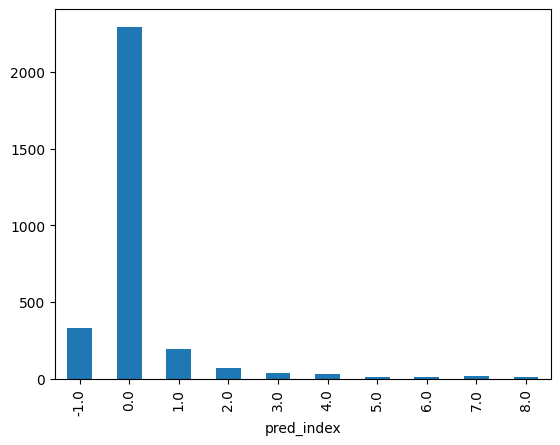

In [22]:
ea_df.pred_index.value_counts().sort_index().iloc[0:10].plot.bar()